In [1]:
import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

/home/sarim.hashmi/anaconda3/envs/AI702/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sarim.hashmi/anaconda3/envs/AI702/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Detected a photo of a cat with confidence 0.707 at location [324.97, 20.44, 640.58, 373.29]
Detected a photo of a cat with confidence 0.717 at location [1.46, 55.26, 315.55, 472.17]


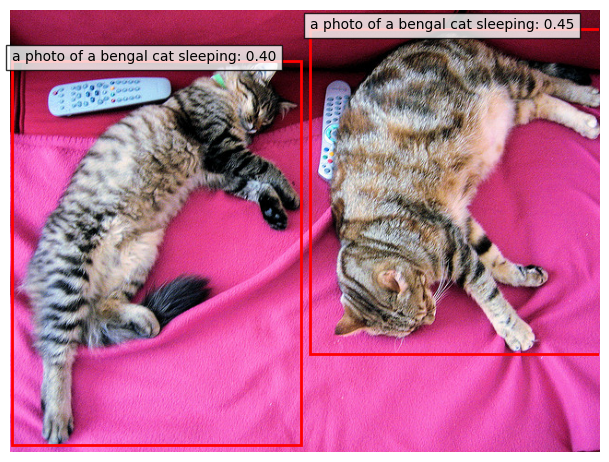

In [4]:
import requests
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Load model and processor
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Download and open the image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Prepare inputs
texts = [["a photo of a bengal cat sleeping", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

# Perform inference
outputs = model(**inputs)

# Post-process the results
target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)

# Prepare the plot
fig, ax = plt.subplots(1)
ax.imshow(image)

# Draw bounding boxes and labels
for box, score, label in zip(results[0]['boxes'], results[0]['scores'], results[0]['labels']):
    xmin, ymin, xmax, ymax = box.tolist()
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin, f"{texts[0][label]}: {score:.2f}", 
            bbox=dict(facecolor='white', alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

/home/sarim.hashmi/anaconda3/envs/AI702/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Files already downloaded and verified


/home/sarim.hashmi/anaconda3/envs/AI702/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


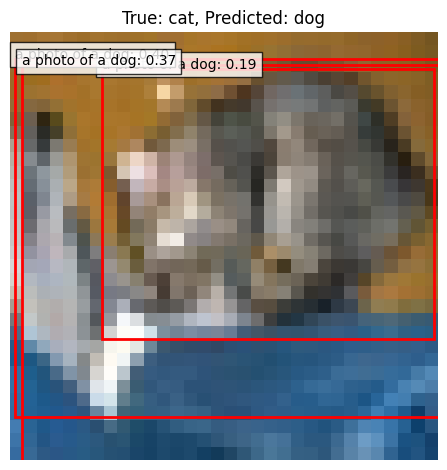

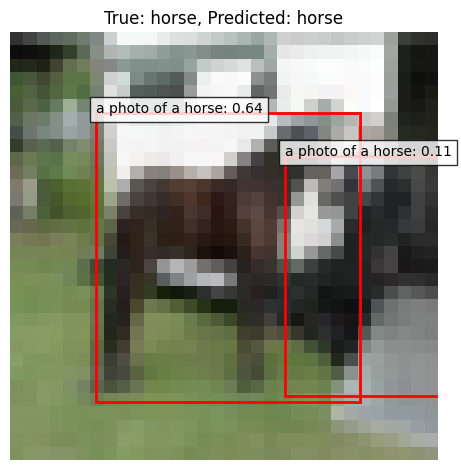

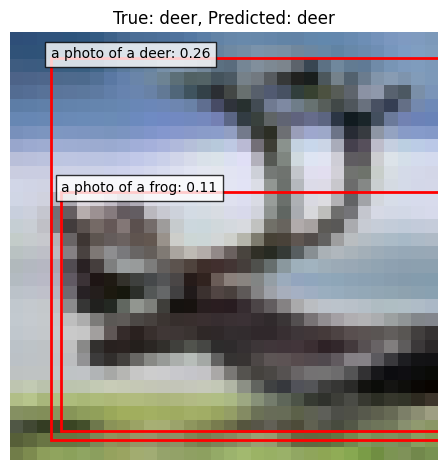

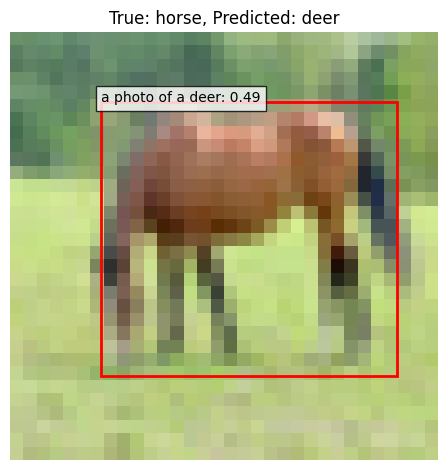

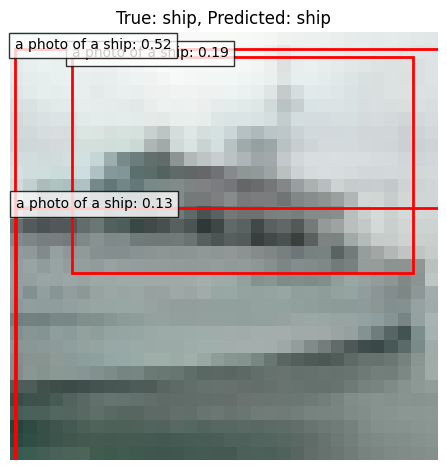

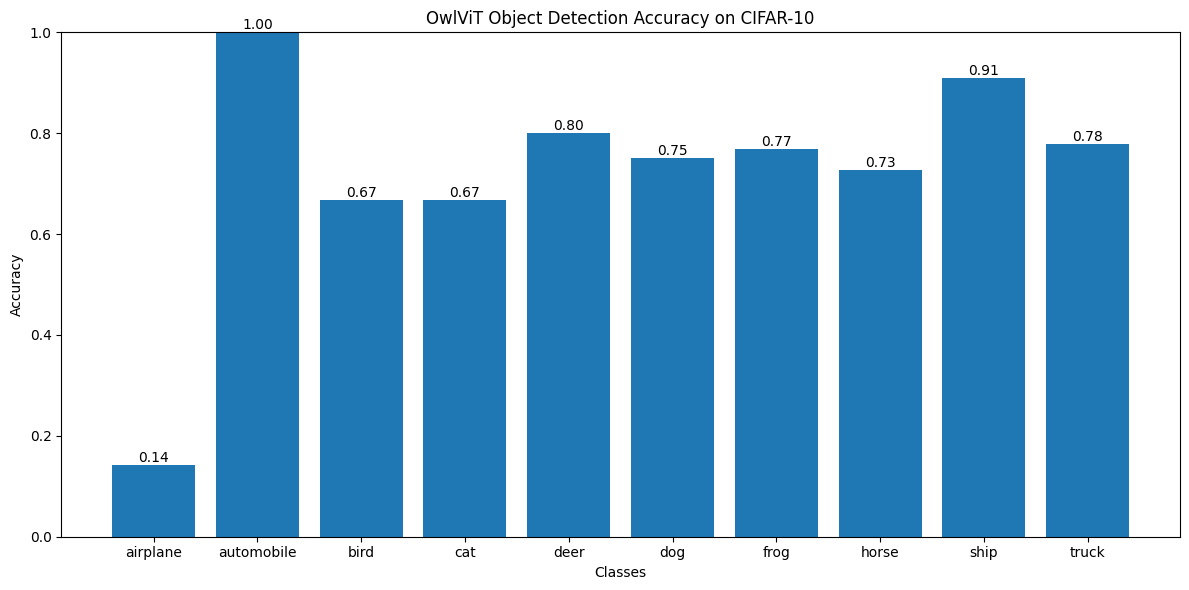

Overall Accuracy: 0.7294


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Load model and processor
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

correct_predictions = {c: 0 for c in classes}
total_predictions = {c: 0 for c in classes}

# Evaluate on test set
model.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(testloader):
        if i >= 100:  # Process only 100 images for brevity
            break
        
        # Convert tensor to PIL Image
        image = transforms.ToPILImage()(image.squeeze(0))
        
        # Prepare inputs
        texts = [["a photo of a " + c for c in classes]]
        inputs = processor(text=texts, images=image, return_tensors="pt").to(device)
        
        # Perform inference
        outputs = model(**inputs)
        
        # Post-process the results
        target_sizes = torch.Tensor([image.size[::-1]]).to(device)
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
        
        # Get the prediction (highest scoring box)
        if len(results[0]['scores']) > 0:
            pred_label = results[0]['labels'][results[0]['scores'].argmax()].item()
            pred_class = classes[pred_label]
            true_class = classes[label.item()]
            
            total_predictions[true_class] += 1
            if pred_class == true_class:
                correct_predictions[true_class] += 1
        
        # Visualize every 20th image
        if i % 20 == 0:
            fig, ax = plt.subplots(1)
            ax.imshow(image)
            
            for box, score, label in zip(results[0]['boxes'], results[0]['scores'], results[0]['labels']):
                xmin, ymin, xmax, ymax = box.tolist()
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                         linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, f"{texts[0][label]}: {score:.2f}", 
                        bbox=dict(facecolor='white', alpha=0.8))
            
            plt.title(f"True: {true_class}, Predicted: {pred_class}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

# Calculate accuracy for each class
accuracies = {c: correct_predictions[c] / total_predictions[c] if total_predictions[c] > 0 else 0 for c in classes}

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(classes, list(accuracies.values()))
plt.title("OwlViT Object Detection Accuracy on CIFAR-10")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for i, (c, acc) in enumerate(accuracies.items()):
    plt.text(i, acc, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print overall accuracy
overall_accuracy = sum(correct_predictions.values()) / sum(total_predictions.values())
print(f"Overall Accuracy: {overall_accuracy:.4f}")

Using device: cuda
Files already downloaded and verified


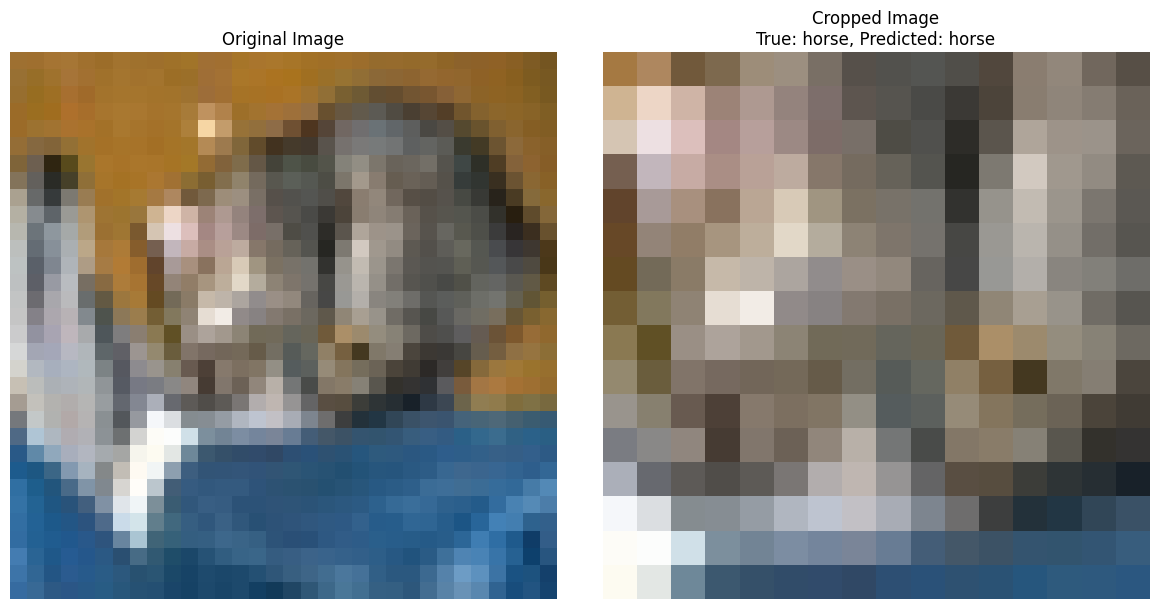

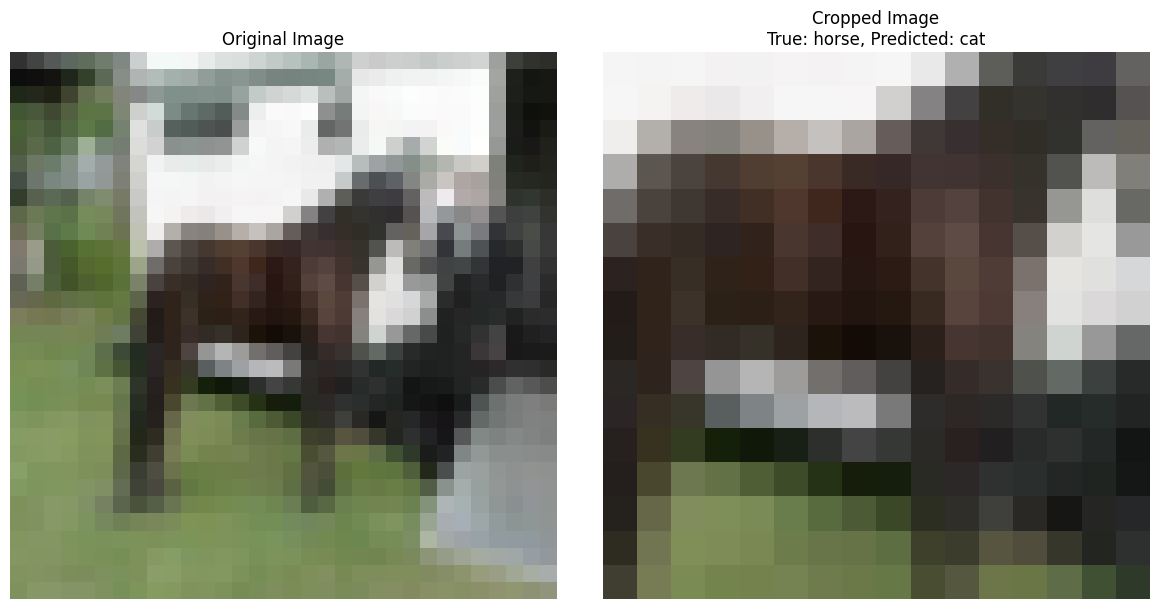

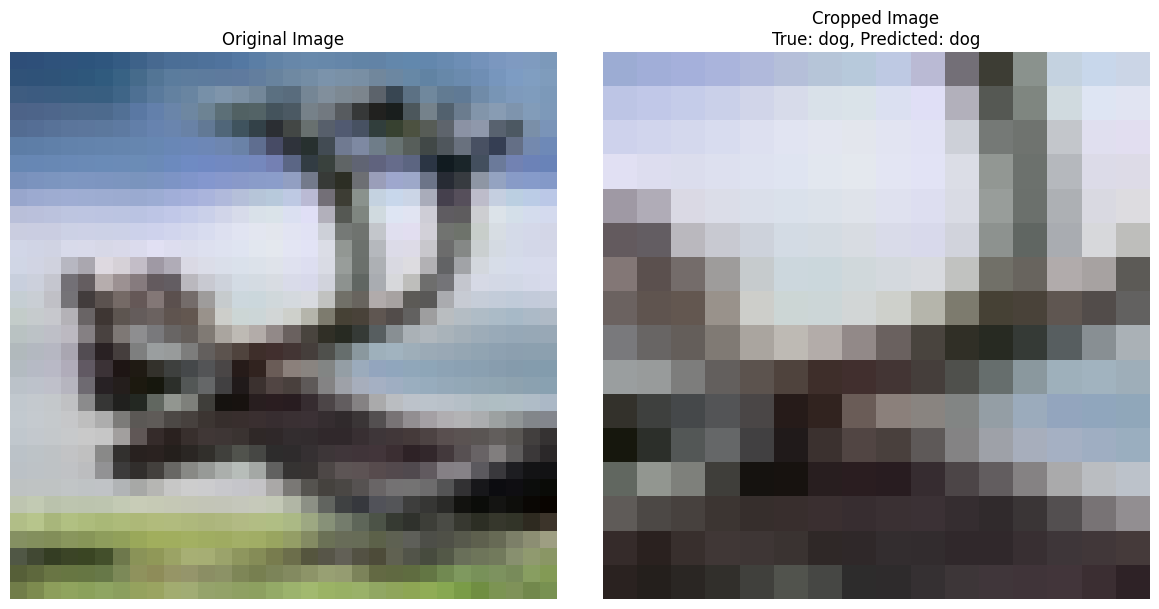

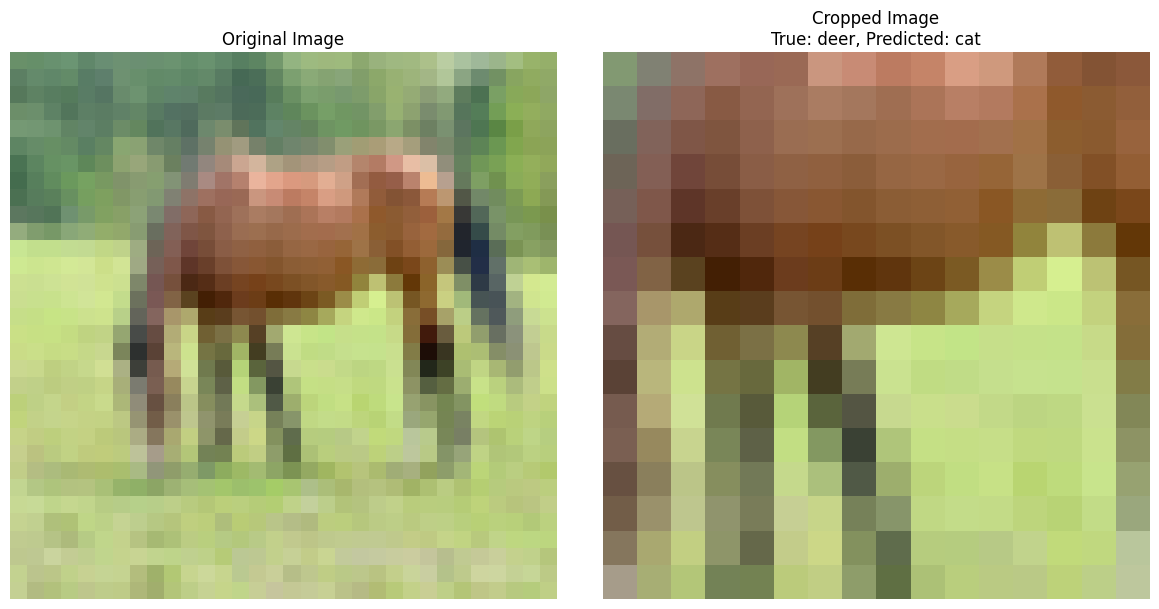

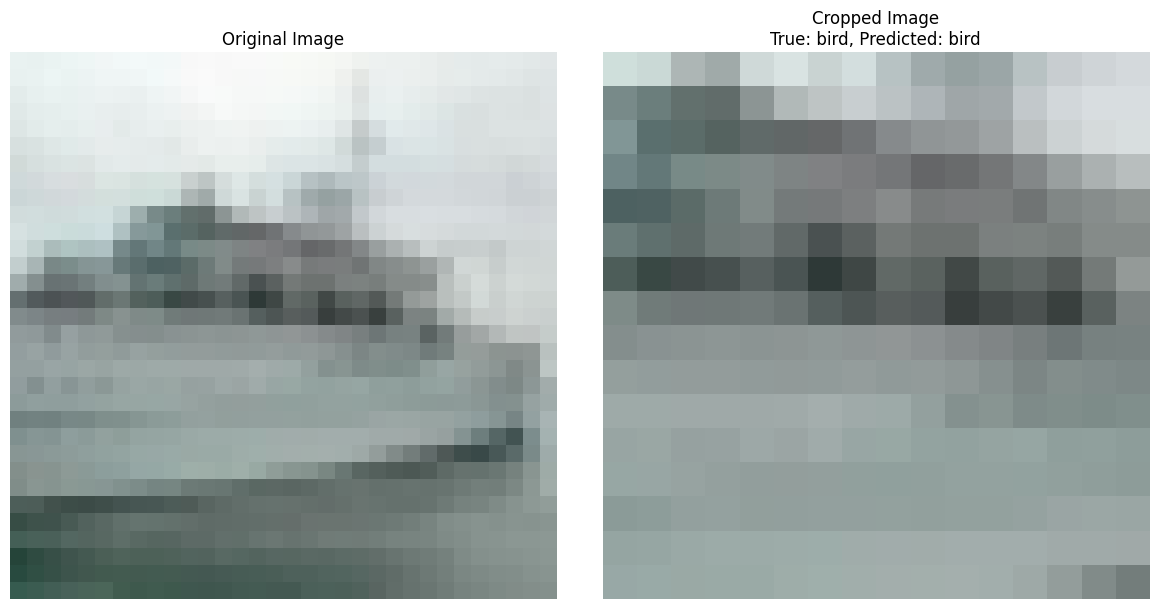

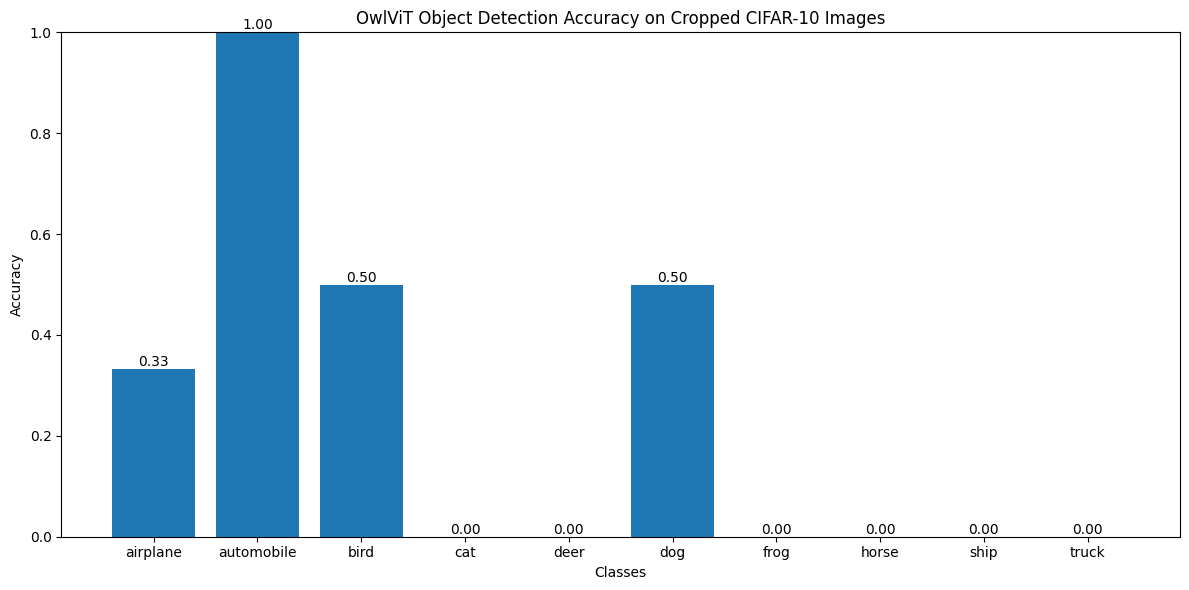

Overall Accuracy on Cropped Images: 0.3125


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Load model and processor
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to crop image
def crop_image(img, crop_percent=0.25):
    w, h = img.size
    crop_w = int(w * crop_percent)
    crop_h = int(h * crop_percent)
    return img.crop((crop_w, crop_h, w - crop_w, h - crop_h))

correct_predictions = {c: 0 for c in classes}
total_predictions = {c: 0 for c in classes}

# Evaluate on test set
model.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(testloader):
        if i >= 100:  # Process only 100 images for brevity
            break
        
        # Convert tensor to PIL Image and crop
        image = transforms.ToPILImage()(image.squeeze(0))
        cropped_image = crop_image(image)
        
        # Prepare inputs
        texts = [["a photo of a " + c for c in classes]]
        inputs = processor(text=texts, images=cropped_image, return_tensors="pt").to(device)
        
        # Perform inference
        outputs = model(**inputs)
        
        # Post-process the results
        target_sizes = torch.Tensor([cropped_image.size[::-1]]).to(device)
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
        
        # Get the prediction (highest scoring box)
        if len(results[0]['scores']) > 0:
            pred_label = results[0]['labels'][results[0]['scores'].argmax()].item()
            pred_class = classes[pred_label]
            true_class = classes[label.item()]
            
            total_predictions[true_class] += 1
            if pred_class == true_class:
                correct_predictions[true_class] += 1
        
        # Visualize every 20th image
        if i % 20 == 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            
            # Original image
            ax1.imshow(image)
            ax1.set_title("Original Image")
            ax1.axis('off')
            
            # Cropped image with predictions
            ax2.imshow(cropped_image)
            for box, score, label in zip(results[0]['boxes'], results[0]['scores'], results[0]['labels']):
                xmin, ymin, xmax, ymax = box.tolist()
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                         linewidth=2, edgecolor='r', facecolor='none')
                ax2.add_patch(rect)
                ax2.text(xmin, ymin, f"{texts[0][label]}: {score:.2f}", 
                        bbox=dict(facecolor='white', alpha=0.8))
            ax2.set_title(f"Cropped Image\nTrue: {true_class}, Predicted: {pred_class}")
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()

# Calculate accuracy for each class
accuracies = {c: correct_predictions[c] / total_predictions[c] if total_predictions[c] > 0 else 0 for c in classes}

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(classes, list(accuracies.values()))
plt.title("OwlViT Object Detection Accuracy on Cropped CIFAR-10 Images")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for i, (c, acc) in enumerate(accuracies.items()):
    plt.text(i, acc, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print overall accuracy
overall_accuracy = sum(correct_predictions.values()) / sum(total_predictions.values())
print(f"Overall Accuracy on Cropped Images: {overall_accuracy:.4f}")